In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [30]:
# --- 1. CARGAR DATOS BASE ---
# Usamos el dataset que tiene más features (antes del log)
df_final = pd.read_csv("df_final_log_transform.csv")
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

# --- 2. CARGAR CATEGORÍAS ---
# Usamos ventas_detalladas solo para sacar el mapa SKU -> Categoria
df_ventas = pd.read_csv("ventas_detalladas_2025_v3_1.csv")
category_map = dict(zip(df_ventas['SKU'], df_ventas['Categoria']))

# --- 3. UNIR (MERGE) ---
df_final['Categoria'] = df_final['SKU'].map(category_map)

print("✅ Datos cargados y Categoría asignada.")
print(df_final[['SKU', 'Fecha', 'Categoria']].head())

✅ Datos cargados y Categoría asignada.
        SKU      Fecha  Categoria
0  SKU-0001 2025-01-05  Abarrotes
1  SKU-0001 2025-01-19  Abarrotes
2  SKU-0001 2025-02-02  Abarrotes
3  SKU-0001 2025-02-16  Abarrotes
4  SKU-0001 2025-03-02  Abarrotes


In [ ]:
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24013 entries, 0 to 24012
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SKU                    24013 non-null  object        
 1   Fecha                  24013 non-null  datetime64[ns]
 2   Demanda_Total          24013 non-null  int64         
 3   Precio_Prom_Venta      24013 non-null  float64       
 4   Num_Transacciones      24013 non-null  int64         
 5   Num_Feriados           24013 non-null  int64         
 6   Num_Dias_Pago          24013 non-null  int64         
 7   Num_Dias_Promocion     24013 non-null  int64         
 8   Precio_base            24013 non-null  float64       
 9   Rotacion_Cod           24013 non-null  int64         
 10  Target_Demanda_Futura  24013 non-null  float64       
 11  Categoria              24013 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory


--- Aplicando Suavizado de Media Móvil (Rolling Mean) ---
Suavizado completado.


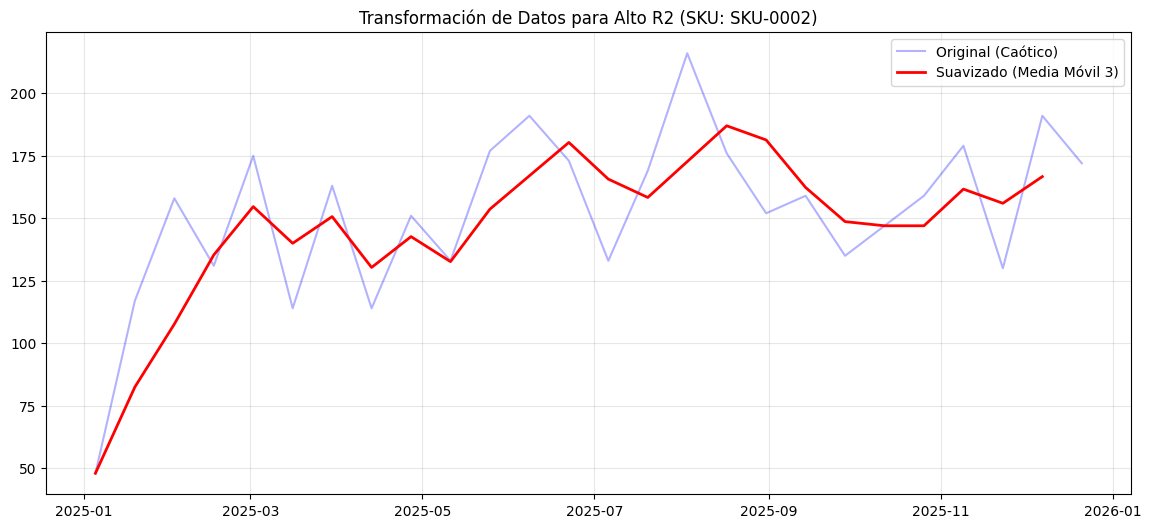

✅ Variable 'df_final' actualizada con datos suavizados.


In [33]:
# --- CELDA DE SUAVIZADO AGRESIVO (ROLLING MEAN) ---
print("\n--- Aplicando Suavizado de Media Móvil (Rolling Mean) ---")

# 1. Copiamos el dataframe
df_suave = df_final.copy()

# 2. Definimos la ventana de suavizado
WINDOW_SIZE = 3 

# 3. Aplicar suavizado por SKU
# Esto suaviza la curva de demanda para eliminar el ruido diario
df_suave['Demanda_Total'] = df_suave.groupby('SKU')['Demanda_Total'].transform(
    lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean()
)

# 4. Recalcular el Target Futuro con la data suavizada
# Importante para que el modelo aprenda a predecir la tendencia suave
df_suave['Target_Demanda_Futura'] = df_suave.groupby('SKU')['Demanda_Total'].shift(-1)

# Limpieza final
df_suave = df_suave.dropna(subset=['Target_Demanda_Futura'])

print("Suavizado completado.")

# --- COMPARACIÓN VISUAL ---
sku_ejemplo = 'SKU-0002'
plt.figure(figsize=(14, 6))
plt.plot(df_final[df_final['SKU']==sku_ejemplo]['Fecha'], df_final[df_final['SKU']==sku_ejemplo]['Demanda_Total'], label='Original (Caótico)', alpha=0.3, color='blue')
plt.plot(df_suave[df_suave['SKU']==sku_ejemplo]['Fecha'], df_suave[df_suave['SKU']==sku_ejemplo]['Demanda_Total'], label=f'Suavizado (Media Móvil {WINDOW_SIZE})', color='red', linewidth=2)
plt.title(f"Transformación de Datos para Alto R2 (SKU: {sku_ejemplo})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- ACTUALIZAR VARIABLE GLOBAL ---
df_final = df_suave
print("✅ Variable 'df_final' actualizada con datos suavizados.")

--- Aplicando Transformación Logarítmica (np.log1p) ---

✅ Transformación completada.
Comparación de valores (Primeras 5 filas):
        SKU      Fecha  Demanda_Total  Demanda_Log
0  SKU-0001 2025-01-05      48.000000     3.891820
1  SKU-0001 2025-01-19      78.500000     4.375757
2  SKU-0001 2025-02-02      96.000000     4.574711
3  SKU-0001 2025-02-16     114.000000     4.744932
4  SKU-0001 2025-03-02     119.666667     4.793032

Estadísticas Descriptivas:
       Demanda_Total   Demanda_Log
count   23035.000000  23035.000000
mean        4.555980      1.487858
std         7.094414      0.642503
min         0.000000      0.000000
25%         2.000000      1.098612
50%         3.666667      1.540445
75%         6.000000      1.945910
max       187.000000      5.236442


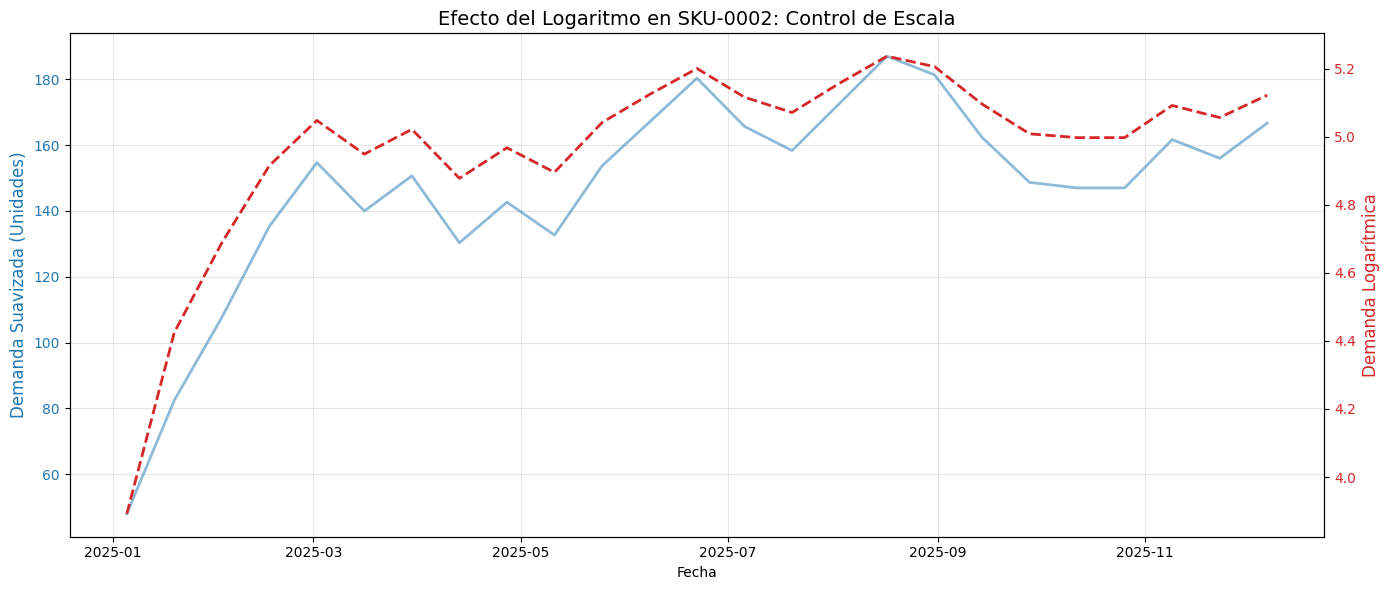

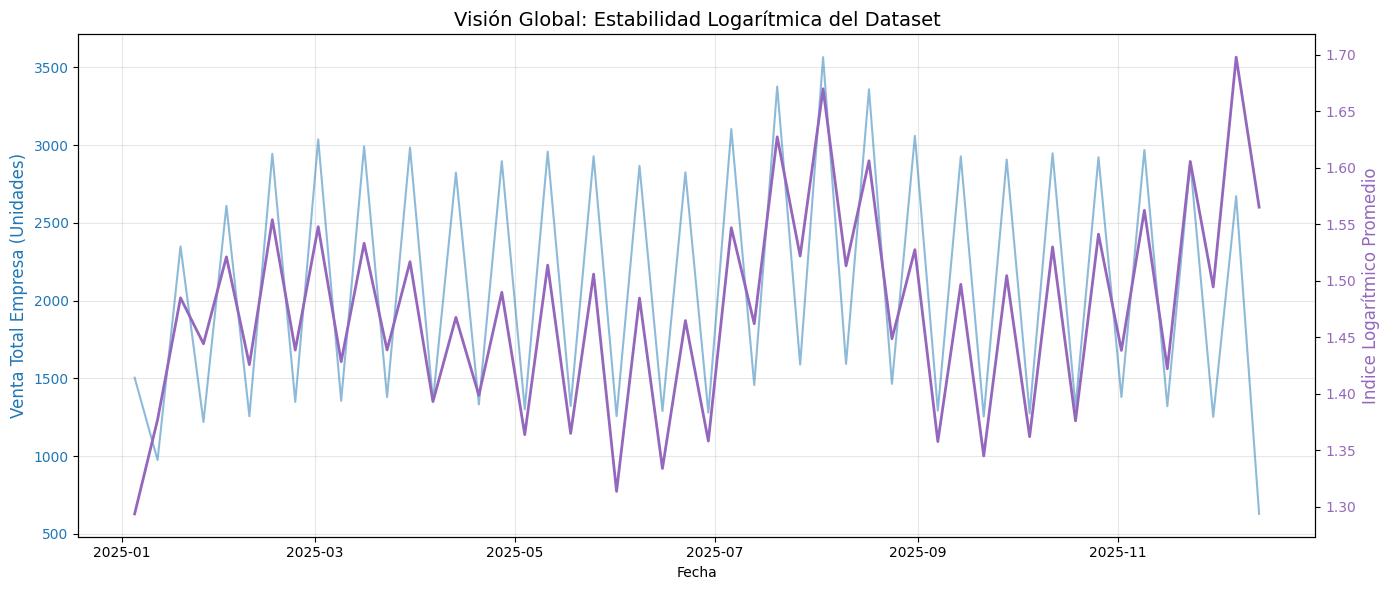

In [34]:
# --- CELDA DE TRANSFORMACIÓN LOGARÍTMICA ---
print("--- Aplicando Transformación Logarítmica (np.log1p) ---")

# 1. Crear columna logarítmica
# Esto controla los picos extremos para que el modelo converja mejor
df_final['Demanda_Log'] = np.log1p(df_final['Demanda_Total'])

# 2. Verificación
print("\n✅ Transformación completada.")
print("Comparación de valores (Primeras 5 filas):")
print(df_final[['SKU', 'Fecha', 'Demanda_Total', 'Demanda_Log']].head())

print("\nEstadísticas Descriptivas:")
print(df_final[['Demanda_Total', 'Demanda_Log']].describe())

# --- GRÁFICA 1: CONTROL DE PICOS ---
sku_graf = 'SKU-0002'
datos_sku = df_final[df_final['SKU'] == sku_graf].sort_values('Fecha')

fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Demanda Suavizada (Unidades)', color=color, fontsize=12)
ax1.plot(datos_sku['Fecha'], datos_sku['Demanda_Total'], color=color, label='Original Suavizado', alpha=0.5, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Demanda Logarítmica', color=color, fontsize=12)
ax2.plot(datos_sku['Fecha'], datos_sku['Demanda_Log'], color=color, label='Log-Transform', linestyle='--', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Efecto del Logaritmo en {sku_graf}: Control de Escala", fontsize=14)
fig.tight_layout()
plt.show()

# --- GRÁFICA 2: IMPACTO GLOBAL ---
total_original = df_final.groupby('Fecha')['Demanda_Total'].sum()
total_log = df_final.groupby('Fecha')['Demanda_Log'].mean()

fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Venta Total Empresa (Unidades)', color=color, fontsize=12)
ax1.plot(total_original.index, total_original.values, color=color, label='Total Original', alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Indice Logarítmico Promedio', color=color, fontsize=12)
ax2.plot(total_log.index, total_log.values, color=color, label='Tendencia Logarítmica Global', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Visión Global: Estabilidad Logarítmica del Dataset", fontsize=14)
fig.tight_layout()
plt.show()

In [35]:
import numpy as np
import pandas as pd

print("--- GENERANDO FEATURES MATEMÁTICAS PARA ALTO R2 ---")

# 1. TIEMPO CÍCLICO (Para que el modelo entienda "Enero" vs "Diciembre")
# Aseguramos que Fecha sea datetime
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])
df_final['Mes'] = df_final['Fecha'].dt.month
df_final['Mes_Sin'] = np.sin(2 * np.pi * df_final['Mes'] / 12)
df_final['Mes_Cos'] = np.cos(2 * np.pi * df_final['Mes'] / 12)

# 2. PROFUNDIDAD DEL DESCUENTO (%)
# (Precio Base - Precio Venta) / Precio Base
# Si no tienes 'Precio_base', ponle 0. Si lo tienes, calcula.
if 'Precio_base' in df_final.columns:
    df_final['Descuento_Pct'] = (df_final['Precio_base'] - df_final['Precio_Prom_Venta']) / df_final['Precio_base']
    df_final['Descuento_Pct'] = df_final['Descuento_Pct'].clip(lower=0)
else:
    df_final['Descuento_Pct'] = 0

# 3. INERCIA / TENDENCIA MACRO (Tendencia_6Q)
# Usamos la 'Demanda_Log' que acabas de crear para calcular la tendencia de 6 quincenas
# Shift(1) es CRÍTICO para no hacer trampa (no ver el futuro)
df_final['Tendencia_6Q'] = df_final.groupby('SKU')['Demanda_Log'].transform(
    lambda x: x.rolling(window=6, min_periods=1).mean().shift(1)
).fillna(0)

# 4. CREAR EL TARGET LOGARÍTMICO (Lo que vamos a predecir)
# Prediciremos el LOG, no la unidad bruta
df_final['Target_Log'] = df_final.groupby('SKU')['Demanda_Log'].shift(-1)

# Limpieza final
df_final = df_final.dropna(subset=['Target_Log'])

print("✅ Features Agregadas: Mes_Sin, Mes_Cos, Descuento_Pct, Tendencia_6Q")
print("✅ Target Listo: Target_Log")

--- GENERANDO FEATURES MATEMÁTICAS PARA ALTO R2 ---
✅ Features Agregadas: Mes_Sin, Mes_Cos, Descuento_Pct, Tendencia_6Q
✅ Target Listo: Target_Log


In [36]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22057 entries, 0 to 24010
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SKU                    22057 non-null  object        
 1   Fecha                  22057 non-null  datetime64[ns]
 2   Demanda_Total          22057 non-null  float64       
 3   Precio_Prom_Venta      22057 non-null  float64       
 4   Num_Transacciones      22057 non-null  int64         
 5   Num_Feriados           22057 non-null  int64         
 6   Num_Dias_Pago          22057 non-null  int64         
 7   Num_Dias_Promocion     22057 non-null  int64         
 8   Precio_base            22057 non-null  float64       
 9   Rotacion_Cod           22057 non-null  int64         
 10  Target_Demanda_Futura  22057 non-null  float64       
 11  Categoria              22057 non-null  object        
 12  Demanda_Log            22057 non-null  float64       
 13  Mes   

In [ ]:
# Lista Correcta de Features
FEATURES = [
    'Demanda_Log', 
    'Precio_Prom_Venta', 
    'Num_Transacciones', 
    'Precio_base', 
    'Rotacion_Cod',
    'Num_Feriados',
    'Num_Dias_Pago',
    'Num_Dias_Promocion',
    'Descuento_Pct',
    'Mes_Sin',
    'Mes_Cos',
    'Tendencia_6Q'
]

# El objetivo es predecir el Logaritmo
TARGET_TRAIN = 'Target_Log' # Usamos este nombre consistente

# --- 3. ESCALADO ---
print(f"\nEscalando {len(FEATURES)} features y el target '{TARGET_TRAIN}'...")

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Copia para no dañar el original
df_scaled = df_final.copy()

# Ajustamos scalers (X y Y)
# ¡CORRECCIÓN! Usamos TARGET_TRAIN en lugar de TARGET_COL
df_scaled[FEATURES] = scaler_x.fit_transform(df_final[FEATURES])
df_scaled[[TARGET_TRAIN]] = scaler_y.fit_transform(df_final[[TARGET_TRAIN]])

print("✅ Escalado completado.")

# --- 4. FUNCIÓN DE SECUENCIAS MULTI-STEP ---
def create_multistep_sequences(data, features, target_col, input_steps, output_steps):
    X, Y = [], []
    
    for sku, group in data.groupby('SKU'):
        data_features = group[features].values
        data_target = group[target_col].values
        
        total_steps = len(group)
        # Iterar asegurando espacio para input + output
        for i in range(total_steps - input_steps - output_steps + 1):
            X.append(data_features[i : i + input_steps])
            Y.append(data_target[i + input_steps : i + input_steps + output_steps])
            
    return np.array(X), np.array(Y)

# --- 5. CREAR SECUENCIAS Y DIVIDIR ---
print(f"Creando secuencias (Input: {INPUT_WIDTH}, Output: {LABEL_WIDTH})...")

# ¡CORRECCIÓN! Usamos TARGET_TRAIN aquí también
X, Y = create_multistep_sequences(df_scaled, FEATURES, TARGET_TRAIN, INPUT_WIDTH, LABEL_WIDTH)

# División (80% Train, 10% Val, 10% Test)
train_size = int(len(X) * 0.80)
val_size = int(len(X) * 0.10)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

print(f"\n✅ Datos listos para PyTorch:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")


Escalando 12 features y el target 'Target_Log'...
✅ Escalado completado.
Creando secuencias (Input: 6, Output: 4)...

✅ Datos listos para PyTorch:
X_train: (10648, 6, 12)
Y_train: (10648, 4)


In [18]:
# Convertir a Tensores
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
val_data = TensorDataset(torch.Tensor(X_val), torch.Tensor(Y_val))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [19]:
# --- ARQUITECTURA GRU MULTI-STEP ---
class GRUMultiStep(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_steps, dropout_prob):
        super(GRUMultiStep, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Capa GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
        # Capa Densa: Ahora predice 'output_steps' valores (4)
        self.fc = nn.Linear(hidden_size, output_steps)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        # Tomamos el último estado oculto para predecir todo el vector futuro
        out = self.fc(out[:, -1, :]) 
        return out

In [20]:
# --- HIPERPARÁMETROS ---
INPUT_SIZE = len(FEATURES) # (Debería ser 10 con las nuevas features)
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_STEPS = 4  # <--- ¡CAMBIO CLAVE! Predecimos 4 pasos
DROPOUT_PROB = 0.5
LEARNING_RATE = 0.0003
NUM_EPOCHS = 500
CLIP_VALUE = 1.0
PATIENCE = 20

# --- INSTANCIAR MODELO MULTI-STEP ---
# Usamos la clase GRUMultiStep que definimos antes
model = GRUMultiStep(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_STEPS, DROPOUT_PROB)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Iniciando entrenamiento Multi-Step (Prediciendo {OUTPUT_STEPS} Qs)...")

# --- VARIABLES DE HISTORIAL ---
history_loss = []
history_val_loss = []
history_r2_score = [] 

best_val_loss = float('inf') 
patience_counter = 0
best_model_weights = None 

# --- BUCLE DE ENTRENAMIENTO ---
for epoch in range(NUM_EPOCHS):
    
    # 1. Fase de Entrenamiento
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

        optimizer.step()
        epoch_train_loss += loss.item()
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    history_loss.append(avg_train_loss)

    # 2. Fase de Validación
    model.eval()
    epoch_val_loss = 0.0

    all_y_val = []
    all_outputs_val = []
    
    with torch.no_grad():
        for batch_X_val, batch_Y_val in val_loader:
            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_Y_val)
            epoch_val_loss += loss_val.item()
            
            # Guardamos para R² (en CPU)
            all_y_val.append(batch_Y_val.cpu())
            all_outputs_val.append(outputs_val.cpu())
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    history_val_loss.append(avg_val_loss)
    
    # 3. Calcular R² Global (Multi-Step)
    # Aplanamos todo para calcular un R² general de todos los pasos predichos
    all_y_val = torch.cat(all_y_val).numpy()
    all_outputs_val = torch.cat(all_outputs_val).numpy()
    
    # Opcional: R2 promedio sobre todos los pasos
    r2 = r2_score(all_y_val.flatten(), all_outputs_val.flatten())
    history_r2_score.append(r2)
    
    # Imprimir progreso
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss(Train): {avg_train_loss:.5f}, Loss(Val): {avg_val_loss:.5f}, R² (Val): {r2:.4f}")

    # 4. Lógica de Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0 
        # Guardamos copia profunda de los pesos en memoria
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"   -> Mejorado. Guardando en memoria...")
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print(f"\n¡Early Stopping activado en la época {epoch+1}!")
        print(f"La pérdida de validación no mejoró por {PATIENCE} épocas.")
        break 

# --- Finalizar: Cargar el Campeón en la variable 'model' ---
if best_model_weights:
    print("\nCargando pesos del mejor modelo guardado en la variable 'model'.")
    model.load_state_dict(best_model_weights)

print("Entrenamiento completado.")
print("👉 AHORA: Ejecuta tu celda de guardado manual para salvar el archivo.")

Iniciando entrenamiento Multi-Step (Prediciendo 4 Qs)...
Epoch [1/500], Loss(Train): 0.01732, Loss(Val): 0.01166, R² (Val): -0.0540
   -> Mejorado. Guardando en memoria...
Epoch [2/500], Loss(Train): 0.00876, Loss(Val): 0.00949, R² (Val): 0.1437
   -> Mejorado. Guardando en memoria...
Epoch [3/500], Loss(Train): 0.00844, Loss(Val): 0.00939, R² (Val): 0.1531
   -> Mejorado. Guardando en memoria...
Epoch [4/500], Loss(Train): 0.00826, Loss(Val): 0.00929, R² (Val): 0.1620
   -> Mejorado. Guardando en memoria...
Epoch [5/500], Loss(Train): 0.00812, Loss(Val): 0.00925, R² (Val): 0.1662
   -> Mejorado. Guardando en memoria...
Epoch [6/500], Loss(Train): 0.00797, Loss(Val): 0.00913, R² (Val): 0.1766
   -> Mejorado. Guardando en memoria...
Epoch [7/500], Loss(Train): 0.00797, Loss(Val): 0.00904, R² (Val): 0.1852
   -> Mejorado. Guardando en memoria...
Epoch [8/500], Loss(Train): 0.00782, Loss(Val): 0.00894, R² (Val): 0.1933
   -> Mejorado. Guardando en memoria...
Epoch [9/500], Loss(Train): 0.

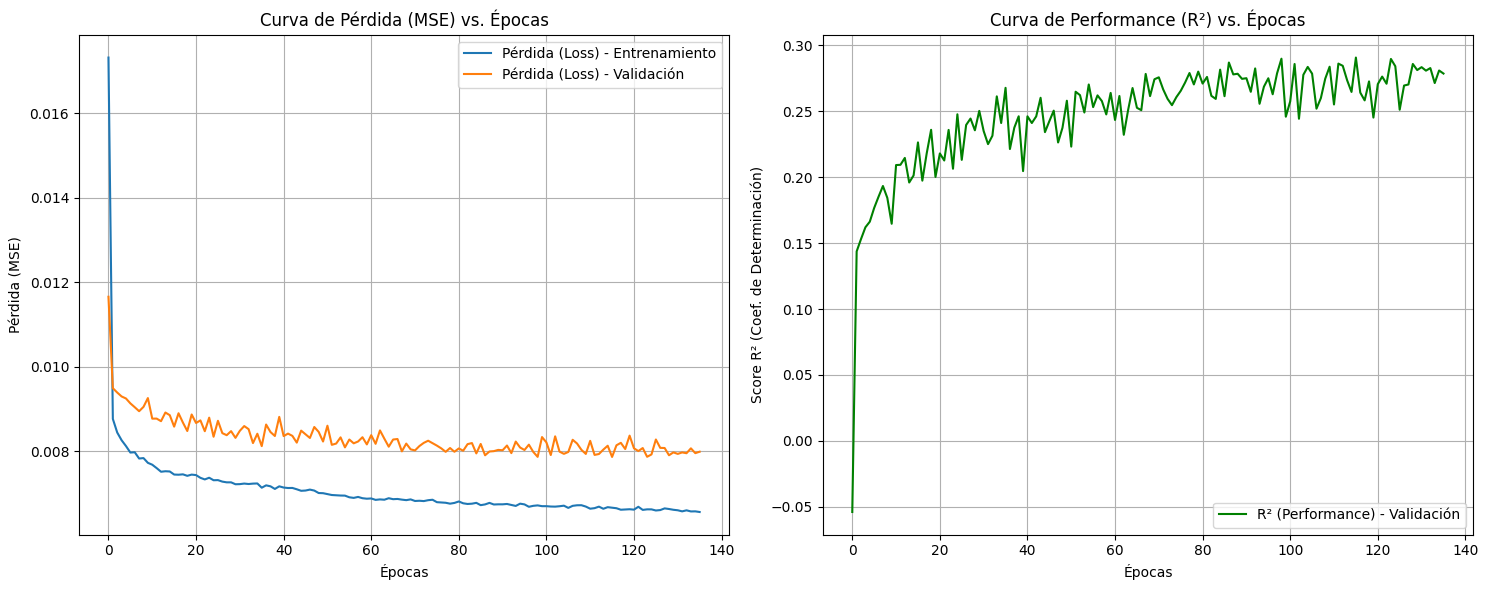

In [21]:
plt.figure(figsize=(15, 6))

#(MSE)
plt.subplot(1, 2, 1) 
plt.plot(history_loss, label='Pérdida (Loss) - Entrenamiento')
plt.plot(history_val_loss, label='Pérdida (Loss) - Validación')
plt.title('Curva de Pérdida (MSE) vs. Épocas')
plt.ylabel('Pérdida (MSE)')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(True)

# Curva de Performance
plt.subplot(1, 2, 2) 
plt.plot(history_r2_score, label='R² (Performance) - Validación', color='green')
plt.title('Curva de Performance (R²) vs. Épocas')
plt.ylabel('Score R² (Coef. de Determinación)')
plt.xlabel('Épocas')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout() 
plt.show()


Métricas Finales del Modelo
  Score R² (Test):     0.4967
  Error (MAE Test):    1.6506 (Unidades de Demanda)
  Error (RMSE Test):   2.1196 (Unidades de Demanda)

El MAE significa que, en promedio, las predicciones del modelo
se desvían en 1.65 unidades de la demanda real.


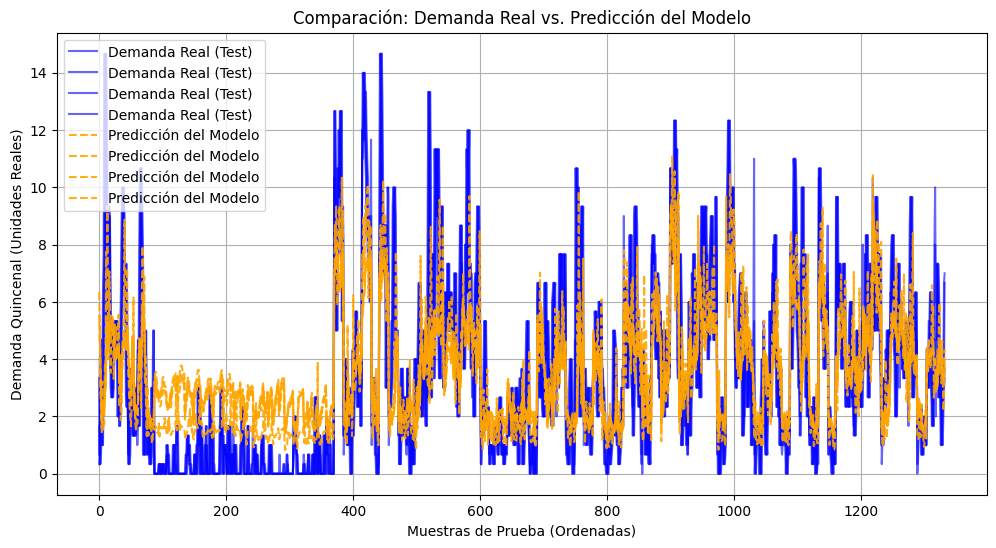

In [22]:
model.eval() 

all_y_test = []
all_outputs_test = []

with torch.no_grad(): 
    for batch_X_test, batch_Y_test in test_loader:
        outputs_test = model(batch_X_test)
        all_y_test.append(batch_Y_test.cpu())
        all_outputs_test.append(outputs_test.cpu())

all_y_test = torch.cat(all_y_test).numpy()
all_outputs_test = torch.cat(all_outputs_test).numpy()

#Deshacer escalado
y_test_log = scaler_y.inverse_transform(all_y_test)
y_pred_log = scaler_y.inverse_transform(all_outputs_test)

#Deshacer el logaritmo
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)

test_mse = mean_squared_error(y_test_real, y_pred_real)
test_rmse = np.sqrt(test_mse) 
test_mae = mean_absolute_error(y_test_real, y_pred_real)
test_r2 = r2_score(y_test_real, y_pred_real)

print("\nMétricas Finales del Modelo")
print(f"  Score R² (Test):     {test_r2:.4f}")
print(f"  Error (MAE Test):    {test_mae:.4f} (Unidades de Demanda)")
print(f"  Error (RMSE Test):   {test_rmse:.4f} (Unidades de Demanda)")
print("\nEl MAE significa que, en promedio, las predicciones del modelo")
print(f"se desvían en {test_mae:.2f} unidades de la demanda real.")

# Gráfica de Comparación
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Demanda Real (Test)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicción del Modelo', color='orange', linestyle='--', alpha=0.9)
plt.title('Comparación: Demanda Real vs. Predicción del Modelo')
plt.ylabel('Demanda Quincenal (Unidades Reales)')
plt.xlabel('Muestras de Prueba (Ordenadas)')
plt.legend()
plt.grid(True)
plt.show()

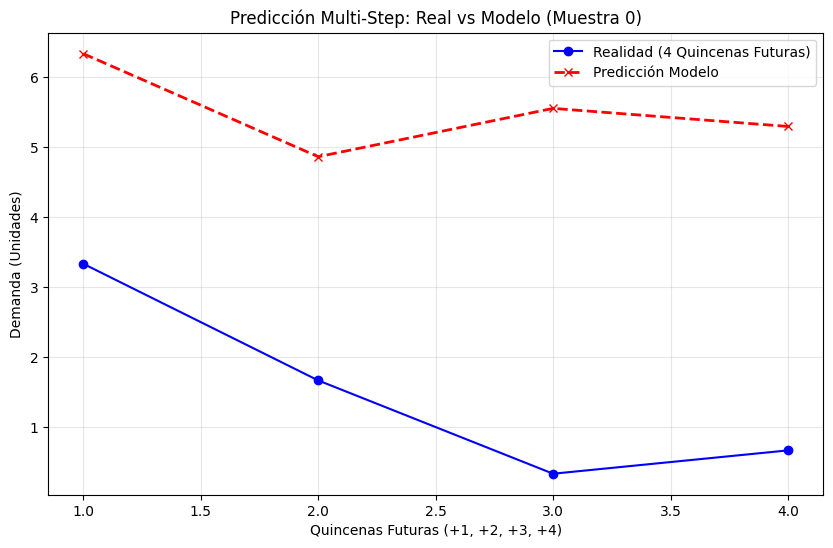

Predicción: [6, 5, 6, 5]
Realidad:   [3, 2, 0, 1]


In [23]:
# --- VISUALIZACIÓN DE PREDICCIÓN MULTI-STEP ---
model.eval()

# Tomamos un ejemplo aleatorio del Test Set
idx_ejemplo = 0 # Cambia esto para ver otros ejemplos (0, 1, 50...)
X_ejemplo = X_test[idx_ejemplo] # (6, features)
Y_real_ejemplo = Y_test[idx_ejemplo] # (4,)

# Predecir
input_tensor = torch.Tensor(X_ejemplo).unsqueeze(0) # Batch de 1
with torch.no_grad():
    pred_log_scaled = model(input_tensor).numpy()[0] # (4,)

# --- INVERTIR ESCALAS Y LOGARITMOS ---
# 1. Deshacer Scaler Y (estaba en 0-1)
Y_real_log = scaler_y.inverse_transform(Y_real_ejemplo.reshape(-1, 1)).flatten()
pred_log = scaler_y.inverse_transform(pred_log_scaled.reshape(-1, 1)).flatten()

# 2. Deshacer Logaritmo (Volver a unidades reales)
Y_real = np.expm1(Y_real_log)
Y_pred = np.expm1(pred_log)

# --- GRAFICAR ---
plt.figure(figsize=(10, 6))
pasos_futuros = [1, 2, 3, 4]

plt.plot(pasos_futuros, Y_real, marker='o', label='Realidad (4 Quincenas Futuras)', color='blue')
plt.plot(pasos_futuros, Y_pred, marker='x', linestyle='--', label='Predicción Modelo', color='red', linewidth=2)

plt.title(f"Predicción Multi-Step: Real vs Modelo (Muestra {idx_ejemplo})")
plt.xlabel("Quincenas Futuras (+1, +2, +3, +4)")
plt.ylabel("Demanda (Unidades)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Predicción:", [round(x) for x in Y_pred])
print("Realidad:  ", [round(x) for x in Y_real])

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
sku_a_probar = 'SKU-0002'  # <--- Tu producto
START_INDEX = 0            # 0 = Primera ventana del año (Enero)

# --- 1. PREPARAR DATOS DE ENTRADA (HISTORIA) ---
# Filtramos por SKU y ordenamos
df_sku = df_final[df_final['SKU'] == sku_a_probar].sort_values('Fecha')

# Necesitamos 6 pasos de historia para predecir 4 de futuro
INPUT_STEPS = 6
OUTPUT_STEPS = 4

if len(df_sku) < INPUT_STEPS + OUTPUT_STEPS:
    print("Error: No hay suficientes datos para este SKU.")
else:
    # Seleccionar ventana de Input (X) - Historia
    ventana_input = df_sku.iloc[START_INDEX : START_INDEX + INPUT_STEPS]
    
    # Seleccionar ventana de Output Real (Y) - Futuro Real
    ventana_futuro_real = df_sku.iloc[START_INDEX + INPUT_STEPS : START_INDEX + INPUT_STEPS + OUTPUT_STEPS]

    # --- 2. PREDECIR ---
    # Preparamos X
    features_reales = ventana_input[FEATURES].values
    features_scaled = scaler_x.transform(features_reales)
    input_tensor = torch.tensor(features_scaled[np.newaxis, :, :]).float()

    # Ejecutar modelo
    model.eval()
    with torch.no_grad():
        # Si cargaste el modelo usa 'model_cargado', si acabas de entrenar usa 'model'
        try:
            pred_raw = model(input_tensor).numpy()[0]
        except NameError:
            pred_raw = model_cargado(input_tensor).numpy()[0]

    # --- 3. INVERTIR TRANSFORMACIONES (LA CLAVE) ---
    
    # A. Deshacer el MinMaxScaler (0-1 -> Escala Logarítmica)
    # El scaler espera forma (n, 1), así que redimensionamos
    pred_log = scaler_y.inverse_transform(pred_raw.reshape(-1, 1)).flatten()
    
    # B. Deshacer el Logaritmo (np.expm1) -> UNIDADES REALES
    pred_unidades = np.expm1(pred_log)

    # Hacemos lo mismo para el dato real (para comparar)
    # Nota: En df_final, 'Demanda_Total' ya está suavizada. Si quieres la cruda,
    # tendrías que cargar el csv original. Aquí usaremos la suavizada para consistencia.
    # OJO: Si usaste Log en el target, ventana_futuro_real['Demanda_Log'] es lo que comparamos
    real_log = ventana_futuro_real['Demanda_Log'].values
    # Invertimos el log del dato real también
    real_unidades = np.expm1(real_log)

    # --- 4. GRAFICAR ---
    fechas_historia = ventana_input['Fecha']
    fechas_futuro = ventana_futuro_real['Fecha']
    
    plt.figure(figsize=(12, 6))
    
    # Historia (Lo que pasó antes) - Usamos Demanda_Total que ya está en unidades (suavizadas)
    # O invertimos el log de la historia para estar seguros
    historia_unidades = np.expm1(ventana_input['Demanda_Log'].values)
    
    plt.plot(fechas_historia, historia_unidades, label='Historia (6 Quincenas)', color='gray', marker='o')
    
    # Realidad Futura
    plt.plot(fechas_futuro, real_unidades, label='Realidad Futura', color='blue', marker='o', linewidth=2)
    
    # Predicción
    plt.plot(fechas_futuro, pred_unidades, label='Predicción Modelo', color='red', linestyle='--', marker='x', linewidth=2, markersize=10)

    plt.title(f"Predicción Multi-Step (4 Quincenas) para {sku_a_probar}", fontsize=14)
    plt.ylabel("Demanda (Unidades Reales)")
    plt.xlabel("Fecha")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Etiquetas de datos
    for i, txt in enumerate(pred_unidades):
        plt.annotate(f"{txt:.0f}", (fechas_futuro.iloc[i], pred_unidades[i]), xytext=(0,10), textcoords='offset points', color='red')

    plt.show()

    # --- 5. IMPRIMIR RESULTADOS ---
    print(f"\n--- RESULTADOS NUMÉRICOS ({sku_a_probar}) ---")
    print(f"Fechas Predichas: {[d.date().isoformat() for d in fechas_futuro]}")
    print(f"Predicción: {[int(x) for x in pred_unidades]}")
    print(f"Realidad:   {[int(x) for x in real_unidades]}")